In [76]:
from sqlalchemy import create_engine, Column, Integer, String, Float, DateTime, ForeignKey, text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship
from faker import Faker
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [78]:
user = "test"
password = "1"
host = "localhost"
port = 5432
database = "postgres"

In [80]:
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

In [113]:
engine.connect()

In [115]:
Base = declarative_base()

# Таблицы ORM (PostgreSQL)

In [118]:
class Customer(Base):
    __tablename__ = 'customers'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    email = Column(String)
    city = Column(String)
    created_at = Column(DateTime, default=datetime.utcnow)
    orders = relationship("Order", back_populates="customer")

class Product(Base):
    __tablename__ = 'products'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    category = Column(String)
    price = Column(Float)

class Order(Base):
    __tablename__ = 'orders'
    id = Column(Integer, primary_key=True)
    customer_id = Column(Integer, ForeignKey("customers.id"))
    order_date = Column(DateTime, default=datetime.utcnow)
    customer = relationship("Customer", back_populates="orders")
    items = relationship("OrderItem", back_populates="order")

class OrderItem(Base):
    __tablename__ = 'order_items'
    id = Column(Integer, primary_key=True)
    order_id = Column(Integer, ForeignKey("orders.id"))
    product_id = Column(Integer, ForeignKey("products.id"))
    quantity = Column(Integer)
    order = relationship("Order", back_populates="items")

class Payment(Base):
    __tablename__ = 'payments'
    id = Column(Integer, primary_key=True)
    order_id = Column(Integer, ForeignKey('orders.id'))
    amount = Column(Float)
    payment_date = Column(DateTime, default=datetime.utcnow)
    method = Column(String)  # card, paypal, crypto

class Return(Base):
    __tablename__ = 'returns'
    id = Column(Integer, primary_key=True)
    order_item_id = Column(Integer, ForeignKey('order_items.id'))
    reason = Column(String)
    return_date = Column(DateTime, default=datetime.utcnow)

class Discount(Base):
    __tablename__ = 'discounts'
    id = Column(Integer, primary_key=True)
    product_id = Column(Integer, ForeignKey('products.id'))
    discount_percent = Column(Float)
    start_date = Column(DateTime)
    end_date = Column(DateTime)

# Создаем все таблицы в базе и сессию для работы с БД

In [104]:
Base.metadata.drop_all(engine)  # Удаление старых таблиц

In [121]:
Base.metadata.create_all(engine)
Session = sessionmaker(bind=engine)
session = Session()

# Генерация данных с помощью Faker

In [124]:
fake = Faker()

In [126]:
# Генерация клиентов
customers = [Customer(name=fake.name(), email=fake.email(), city=fake.city()) for _ in range(30)]
session.add_all(customers)
session.commit()

In [128]:
# Генерация продуктов
categories = ['Electronics', 'Books', 'Clothing', 'Toys']
products = [Product(name=fake.word().capitalize(), category=random.choice(categories), price=round(random.uniform(10, 500), 2)) for _ in range(20)]
session.add_all(products)
session.commit()

In [130]:
# Генерация заказов и позиций
for _ in range(50):
    customer = random.choice(customers)
    order = Order(customer_id=customer.id)
    session.add(order)
    session.commit()

    for _ in range(random.randint(1, 5)):
        item = OrderItem(order_id=order.id, product_id=random.choice(products).id, quantity=random.randint(1, 3))
        session.add(item)

session.commit()

In [132]:
# Генерация платежей
orders = session.query(Order).all()
methods = ['card', 'paypal', 'crypto']
for order in orders:
    amount = sum(item.quantity * session.query(Product).get(item.product_id).price for item in order.items)
    payment = Payment(order_id=order.id, amount=amount, method=random.choice(methods))
    session.add(payment)

session.commit()

In [134]:
# Генерация возвратов
order_items = session.query(OrderItem).all()
for order_item in order_items:
    if random.random() < 0.1:  # 10% возвратов
        return_item = Return(order_item_id=order_item.id, reason=fake.sentence())
        session.add(return_item)

session.commit()

# Запросы SQL для анализа

In [192]:
def select(sql):
    with engine.connect() as conn:
        result = conn.execute(text(sql))
        return pd.DataFrame(result.fetchall(), columns=result.keys())

In [200]:
# Топ 5 товаров по количеству продаж
select("""
SELECT p.name, SUM(oi.quantity) as total
FROM order_items oi
JOIN products p ON oi.product_id = p.id
GROUP BY p.name
ORDER BY total DESC
LIMIT 5;
""")

,name,total
0,Region,32
1,Card,20
2,Mrs,20
3,Hard,20
4,Fall,19


In [202]:
# 2. Доход по категориям
select("""
SELECT p.category, SUM(oi.quantity * p.price) AS revenue
FROM order_items oi
JOIN products p ON oi.product_id = p.id
GROUP BY p.category
ORDER BY revenue DESC;
""")

,category,revenue
0,Clothing,40132.66
1,Books,20856.81
2,Electronics,16740.44
3,Toys,11165.56


In [204]:
# 3. Топ 5 покупателей по сумме покупок
select("""
SELECT c.name, SUM(oi.quantity * p.price) AS total_spent
FROM customers c
JOIN orders o ON c.id = o.customer_id
JOIN order_items oi ON o.id = oi.order_id
JOIN products p ON oi.product_id = p.id
GROUP BY c.name
ORDER BY total_spent DESC
LIMIT 5;
""")

,name,total_spent
0,Lisa Bernard,11656.70
1,Matthew Martin,8950.23
2,Julie Thomas,6930.18
3,Courtney Thomas,5281.61
4,William Lee,4491.56


In [206]:
# 4. Возвраты по товарам
select("""
SELECT p.name, COUNT(r.id) AS returns_count
FROM returns r
JOIN order_items oi ON r.order_item_id = oi.id
JOIN products p ON oi.product_id = p.id
GROUP BY p.name
ORDER BY returns_count DESC;
""")

,name,returns_count
0,Region,3
1,Say,2
2,Stuff,2
3,Hard,2
4,Cell,2
5,Significant,2
6,Card,2
7,Mrs,1
8,Tree,1
9,Fall,1


# Визуализация данных

In [211]:
top_products = select("""
                    SELECT p.name, SUM(oi.quantity) as total
                    FROM order_items oi
                    JOIN products p ON oi.product_id = p.id
                    GROUP BY p.name
                    ORDER BY total DESC
                    LIMIT 5""")

C:\Users\kushh\AppData\Local\Temp\ipykernel_39992\916385646.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, y="total", x="name", palette="viridis")


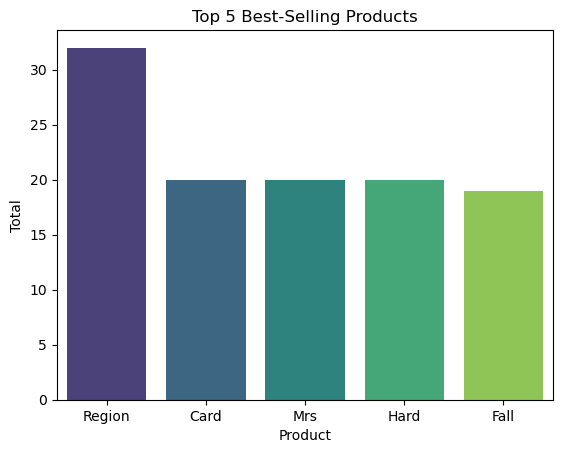

In [233]:
sns.barplot(data=top_products, y="total", x="name", palette="viridis")
plt.title("Top 5 Best-Selling Products")
plt.ylabel("Total")
plt.xlabel("Product")
plt.savefig("images/top5_products.png", bbox_inches='tight')
plt.show();

In [217]:
top_customers = select("""
SELECT c.name, SUM(oi.quantity * p.price) AS total_spent
FROM customers c
JOIN orders o ON c.id = o.customer_id
JOIN order_items oi ON o.id = oi.order_id
JOIN products p ON oi.product_id = p.id
GROUP BY c.name
ORDER BY total_spent DESC
LIMIT 5;
""")

C:\Users\kushh\AppData\Local\Temp\ipykernel_39992\2679814883.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_customers, y="total_spent", x="name", palette="rocket")


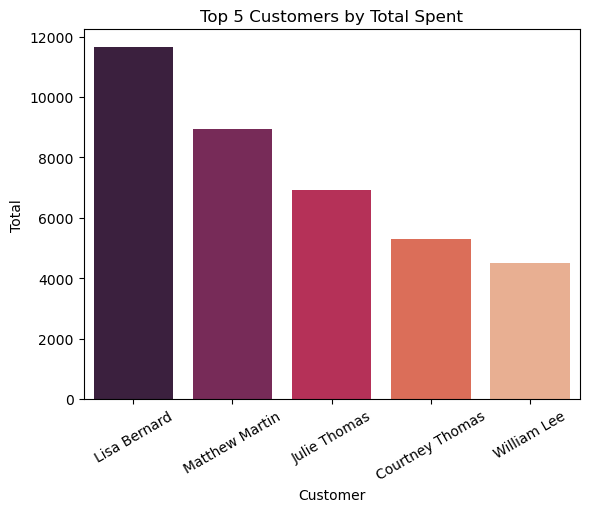

In [235]:
sns.barplot(data=top_customers, y="total_spent", x="name", palette="rocket")
plt.title("Top 5 Customers by Total Spent")
plt.ylabel("Total")
plt.xlabel("Customer")
plt.xticks(rotation = 30)
plt.savefig("images/top_customers.png", bbox_inches='tight')
plt.show();

In [237]:
# 4. Возвраты по товарам
returns = select("""
SELECT p.name, COUNT(r.id) AS returns_count
FROM returns r
JOIN order_items oi ON r.order_item_id = oi.id
JOIN products p ON oi.product_id = p.id
GROUP BY p.name
ORDER BY returns_count DESC;
""")

C:\Users\kushh\AppData\Local\Temp\ipykernel_39992\3325783733.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=returns, y="returns_count", x="name", palette="magma")


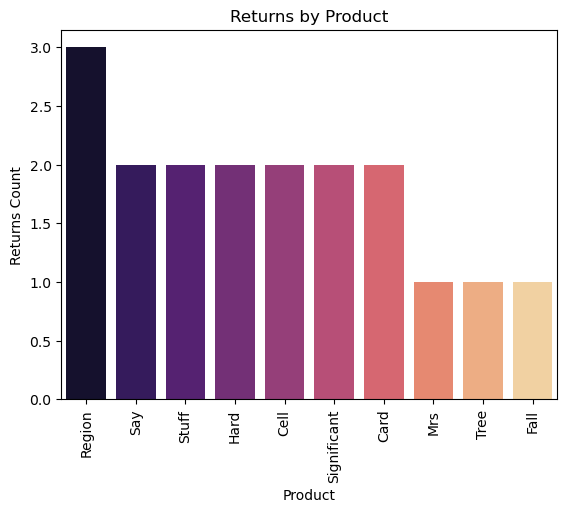

In [245]:
sns.barplot(data=returns, y="returns_count", x="name", palette="magma")
plt.title("Returns by Product")
plt.ylabel("Returns Count")
plt.xlabel("Product")
plt.xticks(rotation = 90)
plt.savefig("images/returns.png", bbox_inches='tight')
plt.show();